# Зарплата по описанию


## Загрузка либ

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import Counter
import torch
from torch.utils.data import Dataset, DataLoader
import time
from IPython.display import clear_output
%matplotlib inline

## Данные

### Загрузка

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip /content/drive/MyDrive/ml2021/job-salary-prediction.zip

Archive:  /content/drive/MyDrive/ml2021/job-salary-prediction.zip
  inflating: Location_Tree.csv       
  inflating: Test_rev1.7z            
  inflating: Test_rev1.zip           
  inflating: Train_rev1.7z           
  inflating: Train_rev1.zip          
  inflating: Valid_rev1.7z           
  inflating: Valid_rev1.csv          
  inflating: mean_benchmark.csv      
  inflating: random_forest_benchmark_test_rev1.csv  
  inflating: test.csv                


In [4]:
!unzip /content/Train_rev1.zip 

Archive:  /content/Train_rev1.zip
  inflating: Train_rev1.csv          


In [5]:
data = pd.read_csv("./Train_rev1.csv", index_col=None)
data.shape

(244768, 12)

### Обзор данных

Одна из проблем с зарплатными данными - они распределены не нормально: многие получают средне и есть длинный хвост тех, кто получает очень много. 

Однако MSE будет сходиться к среднему (которое нерепрезентативно в этом случае). 

Поэтому в данном случае мы логарифмируем таргет, чтобы привести его к более или менее нормальному распределению.

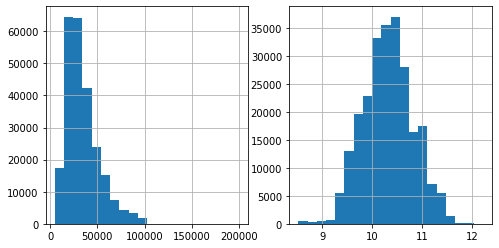

In [6]:
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20);
plt.grid()

plt.subplot(1, 2, 2)
plt.hist(data['Log1pSalary'], bins=20);
plt.grid()

Разделим оставшиеся переменные на:
* Текстовые
* Категориальные

заполним наны просто как строку 'Nan'

In [7]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast missing values to string "NaN"

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
229779,72450096,Real Estate Economist,A leading planning and development consultancy...,Swanscombe Kent South East,Swanscombe,NaN,permanent,Judd Farris,Trade & Construction Jobs,24000 - 26000 per annum + package,25000,totaljobs.com,10.126671
7360,64749035,"Demi Chef De Partie live in, coastal restaura...","Demi Chef De Partie live in, coastal restaura...",East Anglia,Eastern England,NaN,NaN,Clear Selection,Hospitality & Catering Jobs,16000 per annum,16000,caterer.com,9.680407
59102,68690012,"Visual Artist, (****D Studio or Maya or Cinema...","Job Title: Visual Artist, (****D Studio or May...",Alcester Warwickshire West Midlands,Alcester,NaN,permanent,Coburg Banks IT Limited,Creative & Design Jobs,20000 - 22000 per annum,21000,totaljobs.com,9.952325


### Подготовка текста


In [8]:
print("Raw text:")
print(data["FullDescription"][2::100000])

Raw text:
2         Mathematical Modeller / Simulation Analyst / O...
100002    A successful and high achieving specialist sch...
200002    Web Designer  HTML, CSS, JavaScript, Photoshop...
Name: FullDescription, dtype: object


Убираем все бессмысленные символы, оставляем только слова. 

(В общем случае удалять символы не хорошо, но в проcтых задачах можно)

In [9]:
%%time
import nltk
tokenizer = nltk.tokenize.WordPunctTokenizer()

def preparing(line):
    tokens = tokenizer.tokenize(str(line).lower())
    tokens = [token for token in tokens if not set(',.\/[~!@#$%^&*()_+{}":;\']+$').intersection(token)]
    return ' '.join(tokens)

# see task above
data['FullDescription'] = data['FullDescription'].apply(preparing)
data['Title'] = data['Title'].apply(preparing)

CPU times: user 1min 24s, sys: 953 ms, total: 1min 25s
Wall time: 1min 25s


In [10]:
print("Tokenized:")
print(data["FullDescription"][2::100000])

Tokenized:
2         mathematical modeller simulation analyst opera...
100002    a successful and high achieving specialist sch...
200002    web designer html css javascript photoshop ill...
Name: FullDescription, dtype: object


## Классическая модель TF-IDF

In [112]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

In [153]:

vect_descr = TfidfVectorizer(max_features=2000, lowercase=True, analyzer='word',
                        stop_words= 'english', dtype=np.float32)
vect_title = TfidfVectorizer(max_features=10, lowercase=True, analyzer='word',
                        stop_words= 'english', dtype=np.float32)

In [154]:
%%time
descr_vect = vect_descr.fit_transform(data['FullDescription'])
title_vect = vect_title.fit_transform(data['Title'])

CPU times: user 45.8 s, sys: 529 ms, total: 46.3 s
Wall time: 46.4 s


In [173]:
from scipy.sparse import hstack

X = hstack((descr_vect, title_vect)).toarray()
y = data['Log1pSalary']

In [174]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8)
del X

In [176]:
%%time
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score

model = LinearRegression().fit(X_train, y_train)

In [177]:
from sklearn.metrics import mean_absolute_error as MAE
MAE(model.predict(X_val), y_val)

0.22180113

In [181]:
model.predict(X_val[1:2]), y_val[1:2].values

(array([9.498852], dtype=float32), array([9.105091], dtype=float32))

In [182]:
del X_train, X_val, y_val, y_train

## Классика Word2Vec

In [186]:
import gensim.downloader as api
model_wiki = api.load("glove-twitter-100") # предобученная модель на твитах

[==================================================] 100.0% 387.1/387.1MB downloaded


In [215]:
data['Title']

0                               engineering systems analyst
1                                   stress engineer glasgow
2                          modelling and simulation analyst
3         engineering systems analyst mathematical modeller
4               pioneer , miser engineering systems analyst
                                ...                        
244763                                   teacher of science
244764                  teacher of business studies and ict
244765                                      english teacher
244766                                      supply teachers
244767                                           accountant
Name: Title, Length: 244768, dtype: object

In [ ]:
%%time
def get_avg_vec(line):
    lst = line.split()
    vecs = []
    for word in line.split():
        try:
            vecs.append(model_wiki.get_vector(word))
        except KeyError:
            continue
    return np.array(vecs).mean(axis=0) #берем среднее (можно сумму, можно конкатенацию)

X1 = np.array([get_avg_vec(line) for line in data['FullDescription']])

In [216]:
y = data['Log1pSalary']

In [218]:
X_train, X_val, y_train, y_val = train_test_split(X1, y, train_size=0.8)

In [219]:
%%time
model = LinearRegression().fit(X_train, y_train)

CPU times: user 2.33 s, sys: 228 ms, total: 2.55 s
Wall time: 1.7 s


In [221]:
from sklearn.metrics import r2_score

In [222]:
r2_score(model.predict(X_val), y_val)

-0.512450428906726

## Нейронные сети

### Создание словаря токенов

In [11]:
%%time
from collections import Counter

token_counts = Counter(token for col in text_columns # берем обе текстовые колонки
                             for item in data[col]
                             for token in item.split())

CPU times: user 12.5 s, sys: 49.7 ms, total: 12.5 s
Wall time: 12.5 s


In [12]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-5:])))

Total unique tokens : 161296
('and', 2657388)
('the', 2080994)
('to', 2019884)
('a', 1521925)
('of', 1426213)
...
('grzedamcarthurnhs', 1)
('gpled', 1)
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)


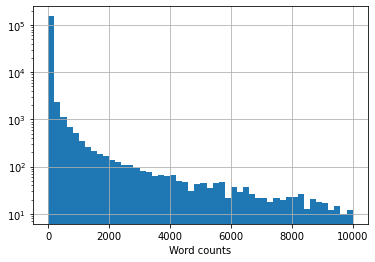

In [13]:
# Let's see how many words are there for each count
plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Word counts");
plt.grid()

Удалим слова, которые встречаются меньше 10 раз

In [14]:
min_count = 10

tokens = [token for token, count in token_counts.items() \
          if count >= min_count ]

In [15]:
len(tokens)

33369

In [16]:
tokens[1]

'systems'

Добавим слова отвечающие за паддинг и за UNKnown word

In [17]:
# Add a special tokens for unknown and empty words 
PAD, UNK = "PAD", "UNK"
tokens = [PAD, UNK] + sorted(tokens)
print("Vocabulary size:", len(tokens))

Vocabulary size: 33371


Строим нашу эмбеддинг таблицу: слово -> токен 

In [18]:
token_to_id = dict((tokens[i], i) for i in range(len(tokens)))

In [19]:
tok = 'stress'
assert tokens[token_to_id[tok]] == tok

len(token_to_id), len(tokens)


(33371, 33371)

### Кодирование текста, создание Даталоадер
Преобразованние текста в лист токенов по нашему словарю

In [20]:
max_len_title = max(len(x.split()) for x in data['Title'])
max_len_descr = max(len(x.split()) for x in data['FullDescription'])

In [21]:
def padd(a, full_len):
    return np.hstack([a, np.zeros(full_len - len(a),dtype=np.int64)])

text_pipeline = lambda line: padd(np.array([token_to_id.get(token,1) for token in line.split()]), max_len_descr)
text_pipeline('programmer at google')

array([23741,  2605, 13132, ...,     0,     0,     0])

Создание батча

Создание даталоадер

In [45]:
class PandasDataset(Dataset):
    def __init__(self, dataframe):
        self.df = dataframe

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        return text_pipeline(self.df.iloc[index]['FullDescription']), 
               self.df.iloc[index]['Log1pSalary']

In [54]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2)

dataloaders = {'train' : DataLoader(PandasDataset(train), 
                              batch_size=32, 
                              shuffle=False),
              'val' : DataLoader(PandasDataset(test), 
                              batch_size=32, 
                              shuffle=False)}

In [48]:
for x, y in dataloaders['train']:
    print(y)
    break

tensor([10.5321, 10.6573, 11.2253, 10.8743, 10.2175, 10.5051, 10.4977, 10.4043,
        11.3794, 10.5967,  9.5929, 10.9778, 10.5051, 10.5967, 10.1267,  9.8522,
        10.3890, 11.1844, 10.0950, 10.4631,  9.9759,  9.9115, 10.5024,  9.9035,
         9.9035, 10.4913, 10.5967, 10.6647,  9.9035,  9.5061, 10.4631, 10.9151])


### Torch Embeddings

Определим сеть как класс

In [26]:
from torch import nn

class TextRegModel(nn.Module): #backward автоматом подтянется из nn.Module

    def __init__(self, vocab_size, embed_dim):
        super(TextRegModel, self).__init__()
        self.embedding = nn.Embedding(num_embeddings= vocab_size, 
                                      embedding_dim = embed_dim)
        self.fc = nn.Linear(in_features=embed_dim, 
                            out_features=1) # линейный слой в одно число
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text):  #text: batch_size x input_len
        embedded = self.embedding(text).mean(axis=1) #усреднение векторов еще можно sum, max. 
        #embedding: batch_size x input_len x vector_len
        return self.fc(embedded)

Определим конфиг обучения

### Обучение!

In [63]:
def train_epoch(model, dataloader, criterion, metric, device, optimizer):
    total_loss = 0
    total_acc  = 0
    n = len(dataloader)    

    model.train(True)
    for i_batch, (X_batch, y_batch) in enumerate(dataloader):
        
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        out = model(X_batch)

        loss = criterion(out, y_batch)
        loss.backward()
        total_loss += loss.item()

        optimizer.step()
        optimizer.zero_grad()


    av_loss = total_loss / n
    av_acc  = total_acc  / n

    return av_loss, av_acc

In [61]:
@torch.no_grad()
def eval_model(model, dataloader, criterion, metric, device):
    total_acc = 0
    n = len(dataloader)  
    
    model.eval()
    for X_batch, y_batch in dataloader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
 
        out = model(X_batch)
        total_acc += criterion(out, y_batch).item()
 
    av_acc = total_acc / n
 
    return av_acc

In [29]:
@torch.no_grad()
def get_result(model, dataloader, device):
    n = len(dataloader)  
    answer = torch.empty(0)

    model.eval()
    for X_batch, _ in dataloader:
        X_batch = X_batch.to(device)
 
        out = model(X_batch)

        answer = torch.cat([answer, out.argmax(-1).to('cpu')])

    return answer

In [31]:
def draw_loss(log):
    clear_output(True)
    np_log = np.array(log)
    plt.title("MSE")
    plt.plot(np_log[:, 0], label='train')
    plt.plot(np_log[:, 1], label='val')
    plt.grid()
    plt.legend()
    plt.show()


In [68]:
def train_model(model, dataloaders, optimizer,
                criterion=nn.MSELoss(), 
                metric=nn.MSELoss(), 
                device=torch.device("cuda:0" if torch.cuda.is_available() else 'cpu'), 
                epochs=50):
    
    model = model.to(device)
    log_acc = []
    for epoch in range(epochs):
        start_time = time.time()
        
        loss, _ = train_epoch(model, dataloaders['train'], criterion, metric, device, optimizer)   
        
        val_loss  =         eval_model(model, dataloaders['val'],   criterion, metric, device)

        if epoch:
            log_acc.append((loss, val_loss))
        
            draw_loss(log_acc)
 
        print("Epoch [{}/{}] Time: {:.2f}s; TrainLoss: {:.4f}; ValLoss: {:.4f}".format(
              epoch + 1, epochs, time.time() - start_time, loss, val_loss))    
    
    return model, val_loss

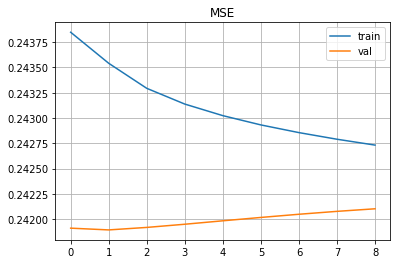

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/50] Time: 121.95s; TrainLoss: 0.2427; ValLoss: 0.2421


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([6, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [ ]:
vocab_size = len(token_to_id)
embed_dim = 64
model = TextRegModel(vocab_size, embed_dim)

for param in model.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

trained_model, val_accuracy, test_accuracy = train_model(model=model, 
                                                         dataloaders=dataloaders, 
                                                         optimizer=optimizer, 
                                                         epochs=50)

------